In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
data = pd.read_csv('data/bank-full.csv', sep = ';', engine = 'python')

In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Input variables:
# bank client data:
- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical:'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')

# related with the last contact of the current campaign:
- contact: contact communication type (categorical: 'cellular','telephone') 
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

# other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

# social and economic context attributes
- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric) 
- cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: 'yes','no')

In [4]:
print("Number of rows",data.size)
print("Number of columns", len(data.columns))
print("Columns")
print(data.columns)

Number of rows 768587
Number of columns 17
Columns
Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')


In [5]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


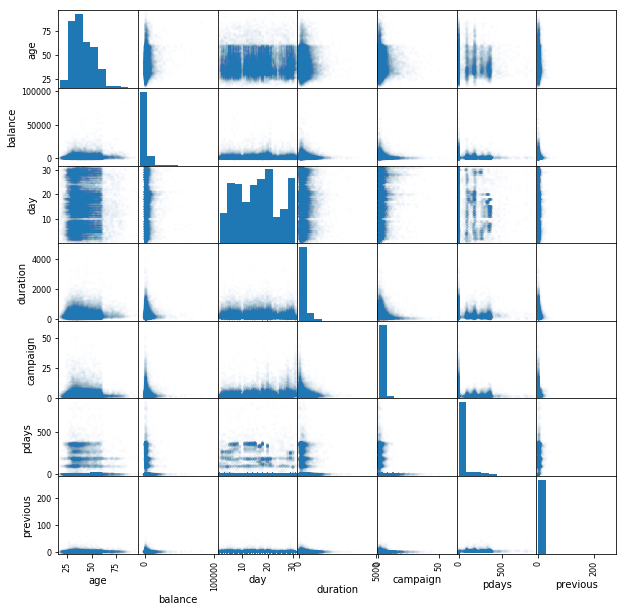

In [6]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha = .01, figsize = (10, 10))
pass

Вычислим попарную корреляцию столбцов

In [7]:
data.corr()

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000


In [8]:
data.describe(include = ['object'])

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


Столбец poutcome практически полностью неизвестен. Возможно, имеет смысл исключить его из тренировочных данных.

### Удалим все строки, где есть пропущенные значения

Удалим стобцы, где присутствует мало значений или сами признаки, вероятно, не имеют большого смысла.

In [9]:
data = data.drop(['poutcome', 'day', 'month','duration'], axis=1)
data = data.dropna(axis = 0)

Разделим признаки на категориальные и числовые, для удобства последующей работы с ней.

In [10]:
data_describe = data.describe(include = [object])
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]

print("Categorical columns", categorical_columns)
print("Numberical columns", numerical_columns)
print("Binary columns", binary_columns)
print("Nonbinary columns", nonbinary_columns)

Categorical columns ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'y']
Numberical columns ['age', 'balance', 'campaign', 'pdays', 'previous']
Binary columns ['default', 'housing', 'loan', 'y']
Nonbinary columns ['job', 'marital', 'education', 'contact']


Переведем все бинарные признаки к одному виду.

In [11]:
for column in binary_columns:
    data.at[data[column] == 'no', column] = 0
    data.at[data[column] == 'yes', column] = 1

# Векторизируем небинарные признаки

Произведем векторизацию категориальных признаков. 
Среди присутствующих нет признаков, имеющих заведомо разную значимость. То есть все значения, внутри каждого признака, можно считать равнозначными. 

In [12]:
data_nonbinary = pd.get_dummies(data[nonbinary_columns])

Многие методы чувствительны к масштабы данных. 
Нормализуем каждый вектор признаков, чтобы разница между значениями различных признаков была не столь велика.

In [13]:
data_numerical = data[numerical_columns]
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)
data_numerical.describe()

,age,balance,campaign,pdays,previous
count,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04
mean,2.135579e-16,-4.067535e-16,1.723756e-14,1.057063e-13,-1.007183e-13
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.159970e+00,-3.081114e+00,-5.693443e-01,-4.114486e-01,-2.519376e-01
25%,-7.473762e-01,-4.237673e-01,-5.693443e-01,-4.114486e-01,-2.519376e-01
50%,-1.823386e-01,-3.002766e-01,-2.465576e-01,-4.114486e-01,-2.519376e-01
75%,6.652178e-01,2.158719e-02,7.622910e-02,-4.114486e-01,-2.519376e-01
max,5.091346e+00,3.309441e+01,1.944343e+01,8.297339e+00,1.191347e+02


# Соединяем все в одну таблицу

In [14]:
data = pd.concat((data_numerical, data_nonbinary, data[binary_columns]), axis = 1)
print(data.shape)
data.describe()

(45211, 31)


,age,balance,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,default,housing,loan,y
count,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,...,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,2.135579e-16,-4.067535e-16,1.723756e-14,1.057063e-13,-1.007183e-13,0.114375,0.215257,0.032890,0.027427,0.209197,...,0.513194,0.294198,0.041074,0.647741,0.064276,0.287983,0.018027,0.555838,0.160226,0.116985
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.318269,0.411005,0.178351,0.163326,0.406740,...,0.499831,0.455687,0.198464,0.477680,0.245247,0.452828,0.133049,0.496878,0.366820,0.321406
min,-2.159970e+00,-3.081114e+00,-5.693443e-01,-4.114486e-01,-2.519376e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.473762e-01,-4.237673e-01,-5.693443e-01,-4.114486e-01,-2.519376e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.823386e-01,-3.002766e-01,-2.465576e-01,-4.114486e-01,-2.519376e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,6.652178e-01,2.158719e-02,7.622910e-02,-4.114486e-01,-2.519376e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,5.091346e+00,3.309441e+01,1.944343e+01,8.297339e+00,1.191347e+02,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Удалим часть тестовых данных, чтобы немного уравновесить количество элементов класса

In [15]:
data = data.drop(data[:2800][data[:2800].y == 0].index)

# X и y

In [16]:
X = data.drop(('y'), axis = 1)
y = data['y']
feature_names = X.columns
N, d = X.shape

Разделим данные на тестовую и тренировочную выборки

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

29734 12744


# kNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix


knn = KNeighborsClassifier(n_neighbors = 10)
knn.set_params(n_neighbors=10)
knn.fit(X_train, y_train)

y_train_predict = knn.predict(X_train)
y_test_predict = knn.predict(X_test)

err_train = np.mean(y_train != y_train_predict)
err_test  = np.mean(y_test  != y_test_predict)

print("Train error", err_train)
print("Test error", err_test)
print("Confusion matrix", confusion_matrix(y_test, y_test_predict))

Train error 0.11808031210062554
Test error 0.1266478342749529
Confusion matrix [[11004   148]
 [ 1466   126]]


# Подбор параметров

In [ ]:
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

knn = KNeighborsClassifier(n_neighbors = best_n_neighbors).fit(X_train, y_train)

err_train = np.mean(y_train != knn.predict(X_train))
err_test  = np.mean(y_test  != knn.predict(X_test))

print("Train error", err_train)
print("Test error", err_test)

# Вывод

Подбор параметров показал, что наименьшая ошибка достигается при колчесвте соседей = 25.
Однако, стоит заметить, что отличие от результата, полученного с количеством соседей = 10, меньше 1%

# SVC

In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))
err_test  = np.mean(y_test  != svc.predict(X_test))

print(err_train, err_test)

# Подбор параметров

In [ ]:
from sklearn.grid_search import GridSearchCV
Cs = 10.**np.arange(-5, 5)
gamma_array = 10.**np.arange(-5, 5)
svc = SVC()
grid = GridSearchCV(svc, param_grid = {'C': Cs, 'gamma': gamma_array})
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_C = grid.best_estimator_.C
print(best_cv_err, best_C)

/home/zebrahead/Libs/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/zebrahead/Libs/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [ ]:
svc = SVC(C = best_C).fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))
err_test  = np.mean(y_test  != svc.predict(X_test))

print(err_train, err_test)

# Значимость признаков

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(d):
    print("%2d. feature '%5s' (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

In [ ]:
d_first = 20
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align = 'center', color = 'r')
plt.xticks(range(d_first), feature_names[indices[:d_first]], rotation = 90)
plt.xlim([-1, d_first])

Как видно из графика, наибольшую роль в объяснении итогового результата играют признаки balance, age, compaign, pdays, previous. Остальные признаки можно попробовать исключить т.к. степень их назимости меньше 1.5%.

# Extremely Randomized Trees

In [ ]:
ert = ensemble.ExtraTreesClassifier(n_estimators = 100).fit(X_train, y_train)

err_train = np.mean(y_train != ert.predict(X_train))
err_test  = np.mean(y_test  != ert.predict(X_test))

print(err_train, err_test)

# Ada boost

In [ ]:
ada = ensemble.AdaBoostClassifier(n_estimators = 1000)
ada.fit(X_train, y_train)

err_train = np.mean(y_train != ada.predict(X_train))
err_test = np.mean(y_test != ada.predict(X_test))

print(err_train, err_test)

# GBT

In [ ]:
gbt = ensemble.GradientBoostingClassifier(n_estimators = 1000)
gbt.fit(X_train, y_train)

err_train = np.mean(y_train != gbt.predict(X_train))
err_test = np.mean(y_test != gbt.predict(X_test))

print(err_train, err_test)

# Neural networks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

num_layers = 4

In [ ]:
#data = pd.read_csv('data/bank.csv', sep = ';', engine = 'python')

## Проведем предобработку данных, аналогично предыдущему модулю

## Разбиваем данные на тренировочную и тестовую выборки

In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop(('y'), axis = 1)
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 7)
N_test, _ = X_test.shape

## Созданим нейронную сеть, для решения задачи классификации

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp_model = MLPClassifier(hidden_layer_sizes = (num_layers,), solver = 'lbfgs', 
                          activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

In [ ]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

In [ ]:
print(mlp_model.score(X_train, y_train), mlp_model.score(X_test, y_test))

## Подбор гиперпараметров

In [ ]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (num_layers,), 
                              solver = 'lbfgs', activation = 'logistic', random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

In [ ]:

plt.semilogx(alpha_arr, train_err, 'b-o', label = 'test')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'train')
plt.xlim([np.max(alpha_arr), np.min(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

In [ ]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

In [ ]:

alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

In [ ]:
alpha_opt = alpha_opt[0]

In [ ]:
layers_num = [1, 2, 3, 4, 10, 100]
test_err = []
train_err = []
for num in layers_num:
    mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (num,), 
                              solver = 'lbfgs', activation = 'logistic', random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

In [ ]:
plt.semilogx(layers_num, train_err, 'b-o', label = 'test')
plt.semilogx(layers_num, test_err, 'r-o', label = 'train')
plt.xlim([np.max(layers_num), np.min(layers_num)])
plt.title('Error vs. layers')
plt.xlabel('layers')
plt.ylabel('error')
plt.legend()
pass

## Обучим классификатор с найденным оптимальным значением alpha и нейронов

In [ ]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (num_layers,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(mlp_model.score(X_train, y_train))
print(mlp_model.score(X_test, y_test))

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train_pred, y_train))

Сеть имеет свойство плохо определять значения класса, соответствующего y = 1. Возможно это связано с тем, что в тренировочной выборке недостаточно значение данного класса.

In [ ]:
from sklearn.model_selection import cross_val_score

def visualize_oob_error(Classifier, estimators_count):
    oob_socres = []
    for count in estimators_count:
        clf = Classifier(n_estimators = count, oob_score=True)
        clf.fit(X_train, y_train)
        oob_scores.append(clf.oob_socre_)
    
    plt.title("OOB score ")
        
    plt.plot(estimators_number, oob_scores)
    plt.legend()
    plt.xlabel('n_estimators')
    plt.ylabel('Mean error')
    plt.show()

def train_classifiers(Classifier, estimators_count):
    train_errors = []
    test_errors = []
    for count in estimators_count:
        clf = Classifier(n_estimators = count)
        #clf.fit(X_train, y_train)
        cross_val_score(clf, X_train, y_train.target, cv=5)
        
        train_errors.append(1 - clf.score(X_train, y_train))
        test_errors.append(1 - clf.score(X_test, y_test))
        
    return train_errors, test_errors

def visualize_error_rate_for_estimators_number(estimators_number, train_error, test_error, plot_name = None):
    if (plot_name != None):
        plt.title(plot_name)
        
    plt.plot(estimators_number, train_error, label='train')
    plt.plot(estimators_number, test_error, label='test')
    plt.legend()
    plt.xlabel('n_estimators')
    plt.ylabel('Mean error')
    plt.show()

In [ ]:
from sklearn import ensemble

classifiers = {"Random forest" : 
               {"classifier" : ensemble.RandomForestClassifier,
               "n_estimators" : range(1, 100)},
              "Extreme Random Forest" :
               {"classifier" : ensemble.ExtraTreesClassifier,
               "n_estimators" : range(1, 100)},
              "Ada boost" :
               {"classifier" : ensemble.AdaBoostClassifier,
               "n_estimators" : range(1, 100)},
              "GBT" :
               {"classifier" : ensemble.GradientBoostingClassifier,
               "n_estimators" : range(1, 100)}}

In [ ]:
for name, parameters in classifiers.items():
    train_errors, test_errors = train_classifiers(parameters["classifier"], parameters["n_estimators"])
    if name == "Random forest":
        visualize_oob_error(parameters["classifier"], parameters["n_estimators"])
    visualize_error_rate_for_estimators_number(forest_size, train_errors, test_errors, name)